# Examples for DateTimeGrid and Functions on it

Especially in the energy business, there is a special need for functions that are preiodic on certain time intervalls (depending on days, hours, weeks, years etc.). Here, special considerations have to be taken if there are time zones with daylight saving or if there is a leap year. For this, the module rivapy.tools.datetime_grid provides tools to handle these cases. This notebook gives a brief overview of the classes and functions.

In [7]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import rivapy.tools.datetime_grid as dt_grid

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## DateTimeGrid

In [162]:
start = pd.Timestamp(2020, 1, 1).tz_localize('CET')
end   = pd.Timestamp(2022, 1, 1).tz_localize('CET')
tg_2yr = dt_grid.DateTimeGrid(start=start, end=end, freq='h')

start = pd.Timestamp(2022, 3, 1).tz_localize('CET')
end   = pd.Timestamp(2022, 4, 1).tz_localize('CET')
tg_1m = dt_grid.DateTimeGrid(start=start, end=end, freq='h')

start = pd.Timestamp(2022, 2, 1).tz_localize('CET')
end   = pd.Timestamp(2022, 2, 2).tz_localize('CET')
tg_2d = dt_grid.DateTimeGrid(start=start, end=end, freq='h')


/home/doeltz/doeltz/development/RiVaPy/rivapy/tools/datetime_grid.py:24: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  self.timegrid = np.array([(d-start).total_seconds()/pd.Timedelta('1Y').total_seconds() for d in self.dates])


## Periodic Functions

In [109]:
if False:
    hours = tg_1m.df.dates
    for t in tg_1m.df.dates:
        print(t, t.tz_convert('UTC') , t.hour, t.tz_convert('UTC').hour)

In [165]:
pf_yearly = dt_grid.PeriodicFunction(lambda x: np.sin(2.0*np.pi*x), frequency='Y', granularity='H', ignore_leap_day=False)
pf_weekly = dt_grid.PeriodicFunction(lambda x: np.sin(2.0*np.pi*x), frequency='W', granularity='H', ignore_leap_day=False)


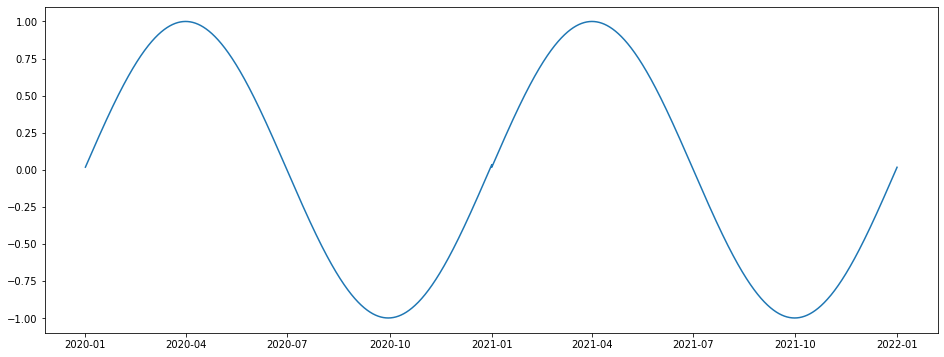

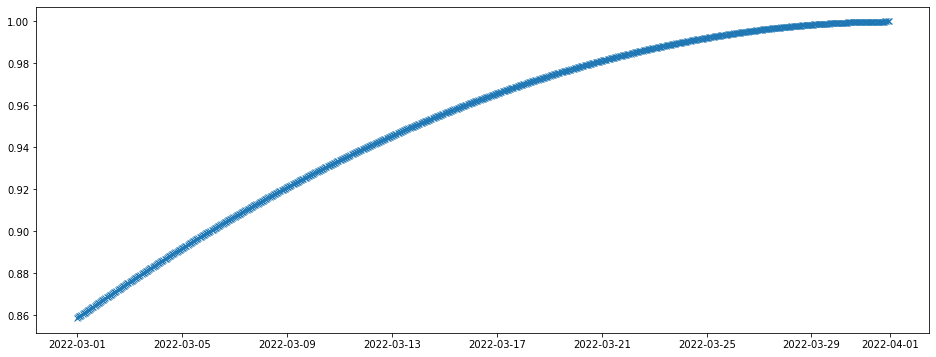

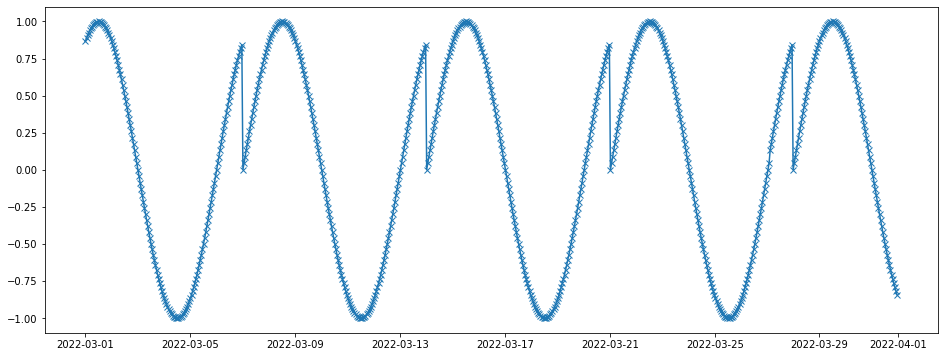

In [166]:
plt.figure(figsize=(16,6))
plt.plot(tg_2yr.dates, pf_yearly.compute(tg_2yr));
plt.figure(figsize=(16,6))
plt.plot(tg_1m.dates, pf_yearly.compute(tg_1m),'-x');


plt.figure(figsize=(16,6))
plt.plot(tg_1m.dates, pf_weekly.compute(tg_1m),'-x');


#plt.xlim(pd.Timestamp(2020, 10, 1).tz_localize('CET'),  pd.Timestamp(2022, 1, 1).tz_localize('CET'))

### Calibration

The previous subsection showed how we can define periodic functions on a DateTimeGrid where periodicity is assumed on a certain period type like a year or day of the week.
We will now see how such a function can be calibrated to noisy data. 

The first step is that we need to define the parametrization of the function that we want to calibrate as a class that 

In [167]:
class CosinusSeasonality:
    def __init__(self, x: np.ndarray = np.array([0,1,0,1,0])):
        self.x = x
        
    def __call__(self, x):
        return self.x[0]*np.cos(2*np.pi*x+self.x[1]) + self.x[2]*np.cos(4*np.pi*x+self.x[3]) + self.x[4]

In [178]:
f = CosinusSeasonality(x=np.array([1.0, 1, 0.9, 1.1, 0.5, -1.0]))
pf_target = dt_grid.PeriodicFunction(f, frequency='Y', granularity='D', ignore_leap_day=True)
start = pd.Timestamp(2010, 1, 1).tz_localize('CET')
end   = pd.Timestamp(2020, 1, 1).tz_localize('CET')
dg = dt_grid.DateTimeGrid(start=start, end=end, freq='d')
values = pf_target.compute(dates)+ np.random.normal(scale = 0.5, size=(dates.df.shape[0]))

In [179]:
f = CosinusSeasonality(x=np.array([0.5, 1, 0.9, 1.1, 0.5, -1.0]))
pf = dt_grid.PeriodicFunction(f, frequency='Y', granularity='D', ignore_leap_day=True)
pf.calibrate(dates,values)

/home/doeltz/anaconda3/envs/pyvacon/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


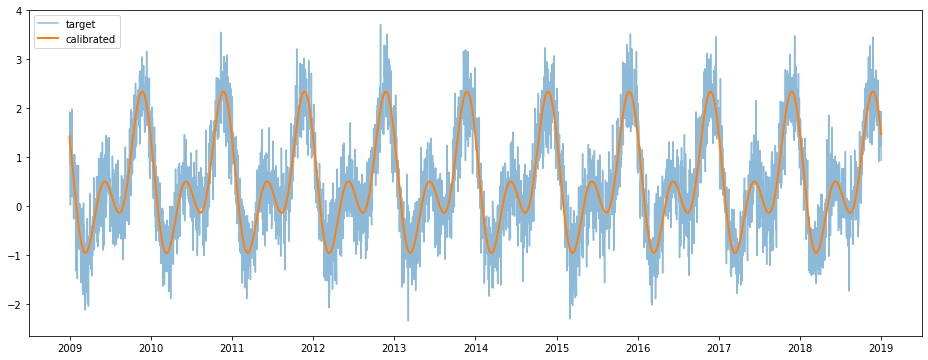

In [177]:
plt.figure(figsize=(16,6))
plt.plot(dg.df.dates, values, alpha=0.5, label='target')
plt.plot(dg.df.dates, pf.compute(dg), linewidth=2.0, label='calibrated')
plt.legend();